In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [ ]:
from sklearn import svm
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import random
import glob

# Data Pre-Processing 

In [ ]:
data_map = []
for sub_dir_path in glob.glob("/content/drive/MyDrive/Mini Project/MRI Brain Images/"+"*"):
    
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)
data_map[5]

In [ ]:
data_map

In [ ]:
data_map[::2][0]

'/content/drive/MyDrive/Mini Project/MRI Brain Images/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif'

In [ ]:
data_map[1::2]

In [ ]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

In [ ]:
len("/content/drive/MyDrive/Mini Project/MRI Brain Images/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_")

97

In [ ]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting

BASE_LEN = 97
END_IMG_LEN =  4 
END_MASK_LEN =  9 


# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : (x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : x[BASE_LEN:-END_MASK_LEN])

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/MyDrive/Mini Project/MRI Brain Images/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_9.tif 
Path to the Mask: /content/drive/MyDrive/Mini Project/MRI Brain Images/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_9_mask.tif


In [ ]:
imgs[159][97:-4]

'10'

In [ ]:
imgs

In [ ]:
masks

In [ ]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))

In [ ]:
brain_df

In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [ ]:
import plotly.graph_objects as go  # using plotly to create interactive plots

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, 
                        y=brain_df['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

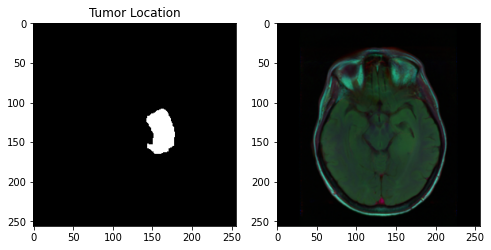

In [ ]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [ ]:
brain_df_train = brain_df.drop(columns=['patient_id'])

# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

# Model Building

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
clf_model =VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
clf_model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
for layer in clf_model.layers:
    layers.trainable = False

In [ ]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

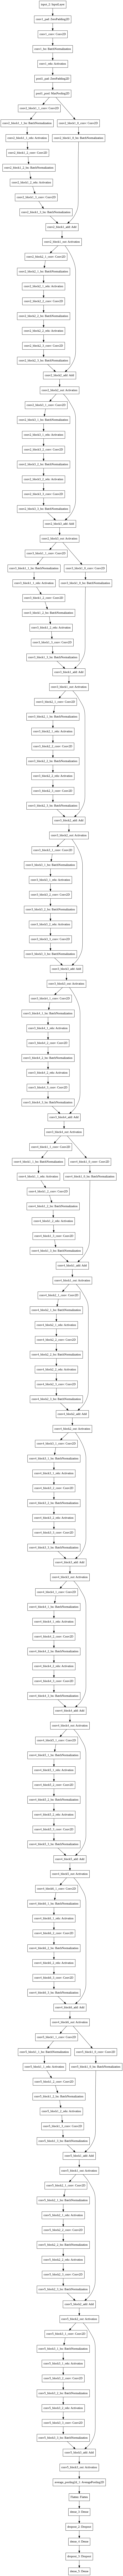

In [ ]:
plot_model(model)

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
callbacks = [checkpointer, earlystopping]

# Model Training

In [ ]:
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 20, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

Epoch 1/20
187/187 [==============================] - 44s 232ms/step - loss: 0.0392 - accuracy: 0.9863 - val_loss: 0.2929 - val_accuracy: 0.9125

Epoch 00001: val_loss did not improve from 0.24581
Epoch 2/20
187/187 [==============================] - 43s 231ms/step - loss: 0.0387 - accuracy: 0.9870 - val_loss: 0.4008 - val_accuracy: 0.8938

Epoch 00002: val_loss did not improve from 0.24581
Epoch 3/20
187/187 [==============================] - 43s 231ms/step - loss: 0.0168 - accuracy: 0.9960 - val_loss: 0.7245 - val_accuracy: 0.8969

Epoch 00003: val_loss did not improve from 0.24581
Epoch 4/20
187/187 [==============================] - 43s 231ms/step - loss: 0.0726 - accuracy: 0.9779 - val_loss: 0.9691 - val_accuracy: 0.8719

Epoch 00004: val_loss did not improve from 0.24581
Epoch 5/20
187/187 [==============================] - 43s 231ms/step - loss: 0.0938 - accuracy: 0.9709 - val_loss: 0.6896 - val_accuracy: 0.8750

Epoch 00005: val_loss did not improve from 0.24581
Epoch 6/20
187/

In [ ]:
# saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Results

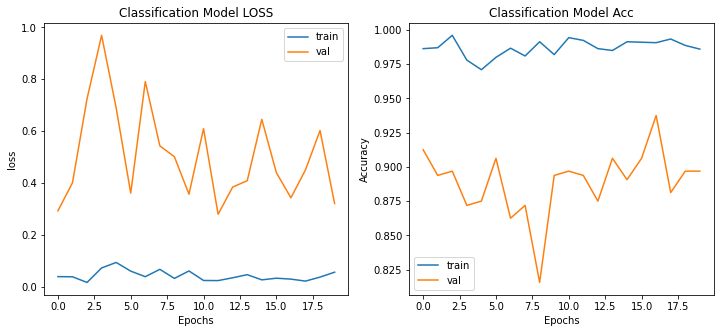

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 3s 70ms/step - loss: 0.5041 - accuracy: 0.9000
Test accuracy : 89.99999761581421 %


0.9254237288135593
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       376
           1       0.92      0.87      0.89       214

    accuracy                           0.93       590
   macro avg       0.92      0.91      0.92       590
weighted avg       0.93      0.93      0.92       590



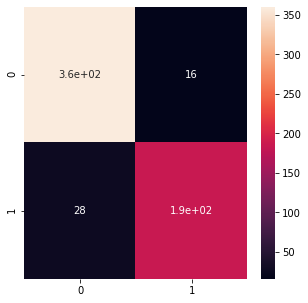

In [ ]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);